<a href="https://colab.research.google.com/github/harithmote98/harith_INFO5731_Fall2021/blob/main/In_class_exercise_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The seventh in-class-exercise (40 points in total, 10/20/2021)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (15 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

**Installing GENSIM Package**

In [33]:
!pip install gensim==3.8.3

**Installing pyLDAvis for visualization**

In [34]:
!pip install pyLDAvis

**Importing Required packages**

In [35]:
# Write your code here
import numpy as np
import pandas as pd
import logging
import pyLDAvis
import pyLDAvis.gensim_models
import json
import warnings
warnings.filterwarnings('ignore')  # To ignore all warnings that arise here to enhance clarity

**Importing gensim packages for LDA and coherence scores**

In [36]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from numpy import array

**Importing the twitter dataset**

In [37]:
import pandas as pd
df =pd.read_csv(r'/tweets.csv',index_col=0)

df.head()

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...


**converting to array**

In [38]:
docs =array(df['text'])
docs

array(['@VirginAmerica What @dhepburn said.',
       "@VirginAmerica plus you've added commercials to the experience... tacky.",
       "@VirginAmerica I didn't today... Must mean I need to take another trip!",
       ...,
       '@SouthwestAir No like I said I could not reach anyone at your company so I had to rent a car and chalk the whole thing up to a loss',
       '@SouthwestAir you guys are so amazing for sending people to meet Imagine Dragons #DestinationDragons 😋',
       "@SouthwestAir BTW, not a weather delay. We've had beautiful weather in Sunny California. #nolove #noexcuses #cali http://t.co/kumtbgER03"],
      dtype=object)

**Define function for tokenize and lemmatizing**

In [39]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

**Defining a function to preprocess the data**

In [40]:
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

In [41]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Perform function on our document**

In [42]:
docs = docs_preprocessor(docs)
docs

[['virginamerica', 'what', 'dhepburn', 'said'],
 ['virginamerica', 'plus', 'added', 'commercial', 'experience', 'tacky'],
 ['virginamerica',
  'didn',
  'today',
  'must',
  'mean',
  'need',
  'take',
  'another',
  'trip'],
 ['virginamerica',
  'really',
  'aggressive',
  'blast',
  'obnoxious',
  'entertainment',
  'your',
  'guest',
  'face',
  'they',
  'have',
  'little',
  'recourse'],
 ['virginamerica', 'really', 'thing', 'about'],
 ['virginamerica',
  'seriously',
  'would',
  'flight',
  'seat',
  'that',
  'didn',
  'have',
  'this',
  'playing',
  'really',
  'only',
  'thing',
  'about',
  'flying'],
 ['virginamerica', 'nearly', 'every', 'time', 'this', 'worm', 'away'],
 ['virginamerica',
  'really',
  'missed',
  'prime',
  'opportunity',
  'without',
  'hat',
  'parody',
  'there',
  'http',
  'mwpg7grezp'],
 ['virginamerica', 'well', 'didn'],
 ['virginamerica', 'amazing', 'arrived', 'hour', 'early', 'good'],
 ['virginamerica',
  'know',
  'that',
  'suicide',
  'second'

**Creating Biagram & Trigram Models**

In [43]:
from gensim.models import Phrases
# Add bigrams and trigrams to docs,minimum count 10 means only that appear 10 times or more.
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

In [44]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

**Remove rare & common tokens**,
**Create a dictionary representation of the documents** 

In [45]:
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 787
Number of documents: 4999
[[(0, 1), (1, 1), (2, 1)]]


**Make a index to word dictionary.**

In [55]:
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

In [56]:
# Set parameters.
num_topics = 20
chunksize = 100
passes = 10
iterations = 400
eval_every = 1 


In [57]:
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)

**Print the Keyword in the 20 topics**

In [58]:
print(lda_model.print_topics())

[(0, '0.001*"space" + 0.001*"small" + 0.001*"partner" + 0.001*"solution" + 0.001*"loyal" + 0.001*"turn" + 0.001*"empty" + 0.001*"forced" + 0.001*"course" + 0.001*"hoping"'), (1, '0.549*"southwestair" + 0.092*"have" + 0.087*"with" + 0.045*"please" + 0.043*"they" + 0.034*"like" + 0.033*"would" + 0.023*"again" + 0.018*"want" + 0.018*"then"'), (2, '0.563*"your" + 0.089*"take" + 0.082*"another" + 0.046*"down" + 0.036*"tried" + 0.034*"mean" + 0.033*"both" + 0.032*"website" + 0.031*"your_website" + 0.016*"must"'), (3, '0.209*"will" + 0.165*"delayed" + 0.133*"only" + 0.101*"guy" + 0.064*"other_airline" + 0.056*"ever" + 0.050*"free" + 0.046*"stop" + 0.031*"gave" + 0.030*"making"'), (4, '0.479*"hour" + 0.203*"good" + 0.108*"amazing" + 0.092*"early" + 0.040*"arrived" + 0.000*"hour_late" + 0.000*"over_hour" + 0.000*"hour_delay" + 0.000*"delay" + 0.000*"connecting_flight"'), (5, '0.119*"never" + 0.115*"very" + 0.112*"minute" + 0.102*"hold" + 0.080*"trying" + 0.076*"response" + 0.063*"last_week" + 0

**The u_mass and c_v topic coherences capture the optimal number of topics by giving the interpretability of these topics a number called coherence score.**

In [59]:
# Compute Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4266991230887583


In [60]:
# Compute Coherence Score using UMass
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence="u_mass")
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -12.898031672962194


In [61]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [62]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
model_list, coherence_values

([<gensim.models.ldamodel.LdaModel at 0x7fe7af3bd610>,
 [0.15086940578628683,
  0.24399216010541264,
  0.2548166172015119,
  0.2830147799970812,
  0.30797934622539513,
  0.31263406913059577,
  0.3311651497435635])

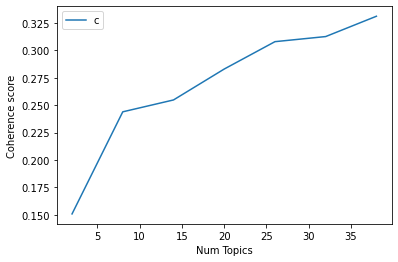

In [63]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## (2) (15 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

**Importing the required packages**

In [64]:
# Write your code here
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt

**Importing the dataset**

In [65]:
import pandas as pd
df =pd.read_csv(r'/tweets.csv',index_col=0)

df.head()

,text
0,@VirginAmerica What @dhepburn said.
1,@VirginAmerica plus you've added commercials t...
2,@VirginAmerica I didn't today... Must mean I n...
3,@VirginAmerica it's really aggressive to blast...
4,@VirginAmerica and it's a really big bad thing...


In [66]:
def load_data(path,file_name):
    """
    Input  : path and file_name
    Purpose: loading text file
    Output : list of paragraphs/documents and)
    """
    documents_list = []
    titles=[]
    with open( os.path.join(path, file_name) ,"r") as fin:
        for line in fin.readlines():
            text = line.strip()
            documents_list.append(text)
    print("Total Number of Documents:",len(documents_list))
    titles.append( text[0:min(len(text),100)] )
    return documents_list,titles
docs_list,titles=load_data(r'','/tweets.csv')

Total Number of Documents: 5074


In [67]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

**pre-processing the data**

In [68]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    print(df.text)
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        i=str(i)
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts
texts=preprocess_data(docs_list)

0                     @VirginAmerica What @dhepburn said.
1       @VirginAmerica plus you've added commercials t...
2       @VirginAmerica I didn't today... Must mean I n...
3       @VirginAmerica it's really aggressive to blast...
4       @VirginAmerica and it's a really big bad thing...
                              ...                        
4994    @SouthwestAir    Promotion e-mail today (Vegas...
4995                 @SouthwestAir safety back in Dallas!
4996    @SouthwestAir No like I said I could not reach...
4997    @SouthwestAir you guys are so amazing for send...
4998    @SouthwestAir BTW, not a weather delay. We've ...
Name: text, Length: 4999, dtype: object


**Cleaning the data**

In [69]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix
dictionary,doc_term_matrix=prepare_corpus(texts)


**Building an Lsa Model**

In [70]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel
lsa_model=create_gensim_lsa_model(texts,10,1000)

[(0, '0.850*"unit" + 0.370*"flight" + 0.096*"get" + 0.092*"thank" + 0.087*"delay" + 0.067*"time" + 0.066*"bag" + 0.064*"servic" + 0.064*"hour" + 0.063*"cancel" + 0.058*"custom" + 0.056*"help" + 0.055*"co" + 0.055*"http" + 0.050*"plane" + 0.050*"2" + 0.046*"wait" + 0.042*"gate" + 0.042*"airlin" + 0.040*"amp" + 0.039*"seat" + 0.039*"late" + 0.038*"book" + 0.038*"fli" + 0.036*"one" + 0.036*"still" + 0.035*"need" + 0.035*"day" + 0.035*"would" + 0.035*"miss" + 0.035*"us" + 0.035*"southwestair" + 0.035*"check" + 0.034*"go" + 0.031*"make" + 0.030*"tri" + 0.030*"pleas" + 0.029*"connect" + 0.028*"flightl" + 0.028*"back" + 0.028*"like" + 0.027*"3" + 0.027*"board" + 0.026*"chang" + 0.026*"last" + 0.026*"agent" + 0.025*"ticket" + 0.025*"call" + 0.025*"problem" + 0.024*"got" + 0.024*"never" + 0.024*"1" + 0.023*"today" + 0.023*"virginamerica" + 0.023*"take" + 0.022*"airport" + 0.021*"issu" + 0.020*"know" + 0.020*"u" + 0.020*"lost" + 0.020*"way" + 0.020*"crew" + 0.020*"min" + 0.019*"work" + 0.019*"tr

**Generating a function to find the coherence values**

In [71]:

def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=10, id2word = dictionary)  # train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values
model_list,coherence_values=compute_coherence_values(dictionary,doc_term_matrix,texts,12,2,1)

In [72]:
coherence_values

[0.3197605188943208,
 0.3032294158208404,
 0.29869517394468176,
 0.32777876186175775,
 0.29807335840538607,
 0.3265448826581453,
 0.2786754701362587,
 0.3081718909801705,
 0.27996934578266086,
 0.3412677389312536]

**Visualizing the Graph**

In [73]:
def plot_graph(doc_clean,start,stop,step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start,stop,step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()

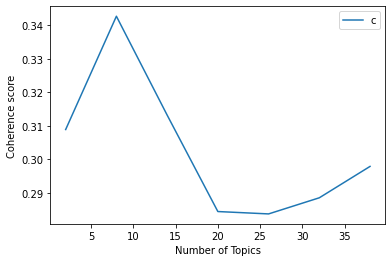

In [74]:
stop=40; start=2; step=6
plot_graph(texts,start,stop,step)

In [75]:
# LSA Model
number_of_topics=20
words=10
document_list,titles=load_data(r'','/tweets.csv')
clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(clean_text,number_of_topics,words)

Total Number of Documents: 5074
0                     @VirginAmerica What @dhepburn said.
1       @VirginAmerica plus you've added commercials t...
2       @VirginAmerica I didn't today... Must mean I n...
3       @VirginAmerica it's really aggressive to blast...
4       @VirginAmerica and it's a really big bad thing...
                              ...                        
4994    @SouthwestAir    Promotion e-mail today (Vegas...
4995                 @SouthwestAir safety back in Dallas!
4996    @SouthwestAir No like I said I could not reach...
4997    @SouthwestAir you guys are so amazing for send...
4998    @SouthwestAir BTW, not a weather delay. We've ...
Name: text, Length: 4999, dtype: object
[(0, '0.850*"unit" + 0.370*"flight" + 0.096*"get" + 0.092*"thank" + 0.087*"delay" + 0.067*"time" + 0.066*"bag" + 0.064*"servic" + 0.064*"hour" + 0.063*"cancel"'), (1, '-0.853*"flight" + 0.405*"unit" + -0.172*"southwestair" + -0.163*"cancel" + -0.107*"virginamerica" + -0.078*"delay" + -0.07

## (3) (10 points) Compare the results generated by the two topic modeling algorithms, which one is better? You should explain the reasons in details.

In [ ]:
# Write your answer here (no code needed for this question)

Latent Dirichlet Allocation(LDA) is a generative model because it generate new topics.The predictive power of a generative model can be measured by analyzing the distributions 
of generated corpus.
LSA (Latent Semantic Analysis) also known as LSI (Latent Semantic Index) LSA uses bag of word(BoW) model, which results in a term-document matrix(occurrence of terms in a document).
Rows represent terms and columns represent documents.LSA learns latent topics by performing a matrix decomposition on the document-term matrix using Singular value decomposition.
LSA is typically used as a dimension reduction or noise reducing technique.
Coherence model is used to measure the accuracy.

Comparsion of two topic modeling algorithms:
Latent Semantic Analysis has lower accuracy than Latent Dirichlet allocation has better accuracy.
Here, The Coherence value for optimal number of topics for LSA is 34 where as for LDA is 42.. LDA has better accuracy that means we can easily generalize LDA model to other new documents. LSA has less interpretability among the topics 
beacuse of dimensionality reduction where as we interpret topic very easily in LDA.The disadvantage of LSA is your model overfits.Coherence model is used to see how well
the models have choosen and how well they fit with actual no. of topics .LDA is a advance level of LSA.    



 